<a href="https://colab.research.google.com/github/sayma-yousuf/IssueDetection/blob/main/Issue_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets scikit-learn imbalanced-learn beautifulsoup4 contractions matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.2 MB/s eta 0:00:00


In [ ]:
# === Mount Google Drive (Colab) ===
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import cycle

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import (
    DistilBertTokenizerFast, DistilBertForSequenceClassification,
    BertTokenizerFast, BertForSequenceClassification,
    RobertaTokenizerFast, RobertaForSequenceClassification,
    get_linear_schedule_with_warmup
)
import torch.optim as optim


In [ ]:
# LOAD DATA
# =========================
df = pd.read_csv('/content/drive/My Drive/annotatted_dataset.csv')

class_counts = df['category'].value_counts()
print(class_counts)

category
Functionality and Features             3878
Performance and Stability              2289
User Interface and UX                  1140
Compatibility and Device Issues         865
Customer Support and Responsiveness     652
Security and Privacy Concerns           146
Name: count, dtype: int64


In [ ]:
# Convert categorical class labels to numeric *codes view* (for plotting only here)
df['category_code'] = df['category'].astype('category').cat.codes

/tmp/ipython-input-487225821.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


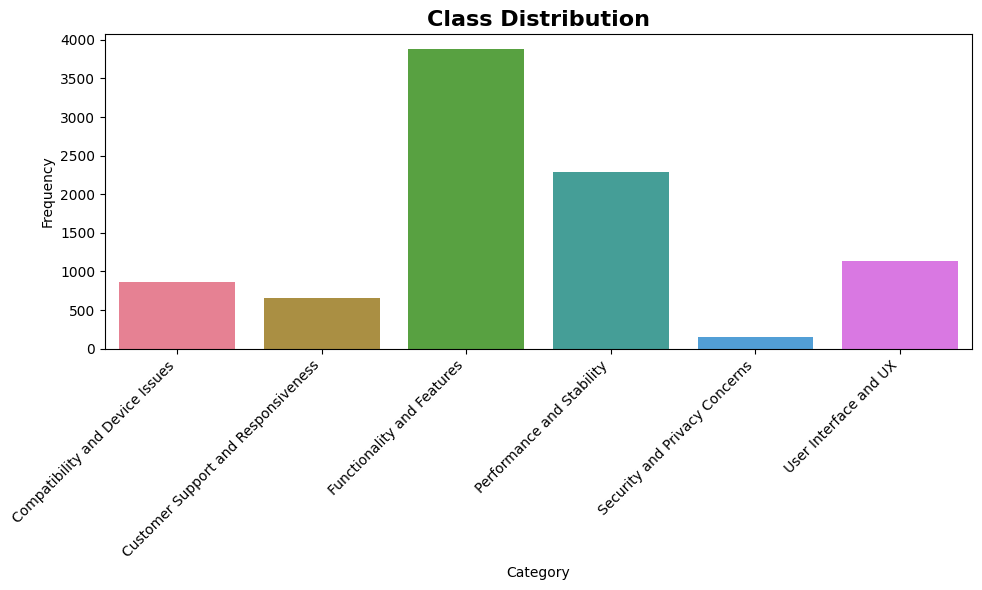

In [ ]:
# Histogram (bar chart) of class distribution with distinct colors per class
plt.figure(figsize=(10, 6))

# Use seaborn's countplot to color each class differently
sns.countplot(
    data=df,
    x='category_code',
    palette=sns.color_palette("husl", n_colors=len(df['category'].astype('category').cat.categories))
)

plt.title('Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Frequency')

# Add readable category names on x-axis
plt.xticks(
    ticks=range(len(df['category'].astype('category').cat.categories)),
    labels=df['category'].astype('category').cat.categories,
    rotation=45,
    ha='right'
)
plt.tight_layout()
plt.show()


Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


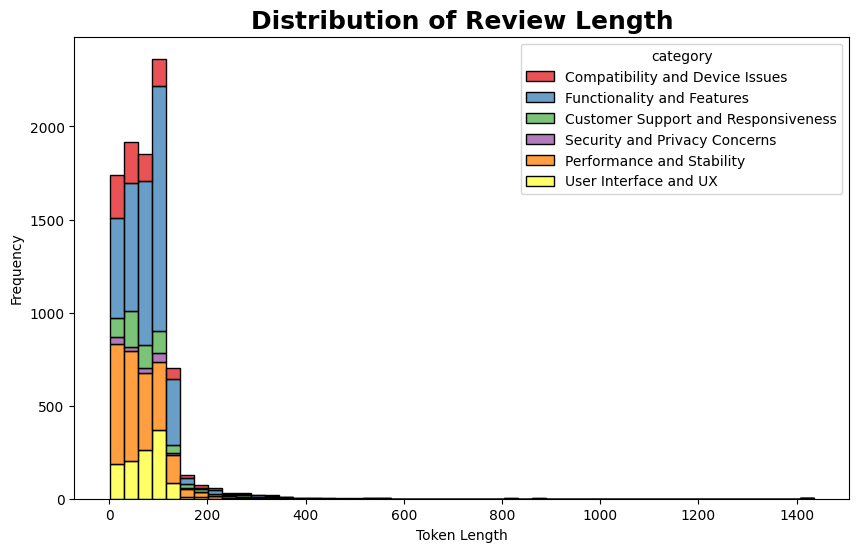

In [ ]:
# 2) (VISUAL) BALANCING PREVIEW — FOR PLOT ONLY
#    IMPORTANT: This balanced copy is NOT used for training/validation to avoid leakage.
# 3) MAP CATEGORIES TO NAMES (unchanged pattern)
# -------------------------
df_codes_for_map = df['category'].astype('category').cat.codes

category_mapping = {
    0: 'Compatibility and Device Issues',
    1: 'Customer Support and Responsiveness',
    2: 'Functionality and Features',
    3: 'Performance and Stability',
    4: 'Security and Privacy Concerns',
    5: 'User Interface and UX'
}

# Apply the mapping to a *label column* for plotting/token length visualization
df['category'] = df_codes_for_map.map(category_mapping)

# =========================
# TOKENIZER & TOKEN LENGTH PLOT (unchanged)
# =========================
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

df['token_length'] = df['Base_Reviews'].apply(lambda x: len(distilbert_tokenizer.tokenize(str(x))))

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='token_length', hue='category', multiple='stack', palette='Set1', bins=50)
plt.title('Distribution of Review Length', fontsize=18, fontweight='bold')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Re-convert categorical labels to numeric codes for modeling (unchanged end state)
# -------------------------
df['category_code'] = df['category'].astype('category').cat.codes
df['category'] = df['category_code']  # modeling uses numeric labels

# =========================
# DATASET CLASS (unchanged)
# =========================
class TextDatasetDistilBERT(Dataset):
    def __init__(self, inputs, labels, attention_masks):
        self.inputs = inputs
        self.labels = labels
        self.attention_masks = attention_masks

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx].clone().detach().to(torch.long),
            'attention_mask': self.attention_masks[idx].clone().detach().to(torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
# =========================
# TRAINING FUNCTION (unchanged signature/prints/logic)
# =========================
def train_model_distilbert(train_loader, val_loader, epochs):
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer_distilbert, num_warmup_steps=0, num_training_steps=total_steps)

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    for epoch in range(epochs):
        model_distilbert.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            optimizer_distilbert.zero_grad()
            inputs = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model_distilbert(inputs, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer_distilbert.step()
            scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

        avg_train_loss = total_loss / len(train_loader) if len(train_loader) > 0 else 0.0
        avg_train_accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(avg_train_accuracy)

        # Validation
        model_distilbert.eval()
        val_loss = 0
        correct_predictions = 0
        total_samples = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input_ids'].to(device)
                attention_masks = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model_distilbert(inputs, attention_mask=attention_masks, labels=labels)
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct_predictions += torch.sum(preds == labels).item()
                total_samples += labels.size(0)

        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0.0
        avg_val_accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(avg_val_accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}')

    return model_distilbert, history

In [ ]:
# DEVICE
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# K-FOLD CV (fixed: shuffle+random_state; reinit model+optimizer each fold;
#            tokenize and upsample INSIDE each fold on TRAIN ONLY)
# =========================
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies_distilbert = []
train_losses_distilbert = []
val_losses_distilbert = []
train_accuracies_distilbert = []
val_accuracies_distilbert = []

# NEW: aggregate across folds
all_true_labels = []
all_pred_labels = []
all_pred_probs = []

# Helper: class balancing ONLY on the training fold
def upsample_per_class(train_df):
    cls_counts = train_df['category'].value_counts()
    majority_n = cls_counts.max()
    upsampled_parts = []
    for cls in cls_counts.index:
        part = train_df[train_df['category'] == cls]
        if len(part) < majority_n:
            part = resample(part, replace=True, n_samples=majority_n, random_state=42)
        upsampled_parts.append(part)
    return pd.concat(upsampled_parts).sample(frac=1.0, random_state=42).reset_index(drop=True)

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(df), start=1):
    # Split the original df into train/val
    train_df = df.iloc[train_idx].copy()
    val_df = df.iloc[val_idx].copy()

    # Upsample INSIDE TRAIN ONLY
    train_df_bal = upsample_per_class(train_df)

    # Tokenize INSIDE THE FOLD to avoid leakage
    tokenized_train = distilbert_tokenizer(
        train_df_bal['Base_Reviews'].astype(str).tolist(),
        padding='max_length', truncation=True, max_length=128, return_tensors='pt', return_attention_mask=True
    )
    tokenized_val = distilbert_tokenizer(
        val_df['Base_Reviews'].astype(str).tolist(),
        padding='max_length', truncation=True, max_length=128, return_tensors='pt', return_attention_mask=True
    )

    # Labels
    train_labels_distilbert_fold = train_df_bal['category'].values
    val_labels_distilbert_fold = val_df['category'].values

    # Create datasets/dataloaders
    train_dataset_distilbert = TextDatasetDistilBERT(
        tokenized_train['input_ids'], train_labels_distilbert_fold, tokenized_train['attention_mask']
    )
    val_dataset_distilbert = TextDatasetDistilBERT(
        tokenized_val['input_ids'], val_labels_distilbert_fold, tokenized_val['attention_mask']
    )

    train_loader_distilbert = DataLoader(train_dataset_distilbert, batch_size=16, shuffle=True)
    val_loader_distilbert   = DataLoader(val_dataset_distilbert, batch_size=16)

    # Re-initialize model and optimizer EACH fold
    model_distilbert = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', num_labels=len(df['category'].unique())
    )
    model_distilbert.to(device)
    optimizer_distilbert = AdamW(model_distilbert.parameters(), lr=2e-5)

    # Train
    model_distilbert, history_distilbert = train_model_distilbert(train_loader_distilbert, val_loader_distilbert, epochs=6)

    # Collect history (unchanged pattern)
    train_losses_distilbert.extend(history_distilbert['train_loss'])
    val_losses_distilbert.extend(history_distilbert['val_loss'])
    train_accuracies_distilbert.extend(history_distilbert['train_accuracy'])
    val_accuracies_distilbert.extend(history_distilbert['val_accuracy'])

    # Evaluate on this fold's validation set; AGGREGATE across folds
    model_distilbert.eval()
    fold_preds = []
    fold_true = []
    fold_probs = []
    with torch.no_grad():
        for batch in val_loader_distilbert:
            inputs = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model_distilbert(inputs, attention_mask=attention_masks)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            preds = torch.argmax(outputs.logits, dim=1)

            fold_probs.extend(probs.cpu().numpy())
            fold_preds.extend(preds.cpu().numpy())
            fold_true.extend(labels.cpu().numpy())

    # Per-fold accuracy
    accuracy_distilbert = np.mean(np.array(fold_preds) == np.array(fold_true)) if len(fold_true) > 0 else 0.0
    accuracies_distilbert.append(accuracy_distilbert)

    # Extend global aggregates
    all_true_labels.extend(fold_true)
    all_pred_labels.extend(fold_preds)
    all_pred_probs.extend(fold_probs)

# Print average accuracy across folds
if len(accuracies_distilbert) > 0:
    print(f"Mean CV Accuracy: {np.mean(accuracies_distilbert):.4f} ± {np.std(accuracies_distilbert):.4f}")
else:
    print("No accuracies were computed.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.7852, Train Accuracy: 0.7190, Val Loss: 0.8380, Val Accuracy: 0.7441
Epoch 2, Train Loss: 0.2615, Train Accuracy: 0.9168, Val Loss: 0.9536, Val Accuracy: 0.7525
Epoch 3, Train Loss: 0.1288, Train Accuracy: 0.9620, Val Loss: 1.0694, Val Accuracy: 0.7430
Epoch 4, Train Loss: 0.0877, Train Accuracy: 0.9753, Val Loss: 1.1590, Val Accuracy: 0.7402
Epoch 5, Train Loss: 0.0689, Train Accuracy: 0.9800, Val Loss: 1.2038, Val Accuracy: 0.7514
Epoch 6, Train Loss: 0.0545, Train Accuracy: 0.9834, Val Loss: 1.2526, Val Accuracy: 0.7603


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.7810, Train Accuracy: 0.7184, Val Loss: 0.8228, Val Accuracy: 0.7174
Epoch 2, Train Loss: 0.2779, Train Accuracy: 0.9115, Val Loss: 0.8848, Val Accuracy: 0.7698
Epoch 3, Train Loss: 0.1393, Train Accuracy: 0.9605, Val Loss: 1.0236, Val Accuracy: 0.7547
Epoch 4, Train Loss: 0.0966, Train Accuracy: 0.9727, Val Loss: 1.1011, Val Accuracy: 0.7670
Epoch 5, Train Loss: 0.0713, Train Accuracy: 0.9793, Val Loss: 1.1575, Val Accuracy: 0.7642
Epoch 6, Train Loss: 0.0603, Train Accuracy: 0.9817, Val Loss: 1.1999, Val Accuracy: 0.7681


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.7937, Train Accuracy: 0.7166, Val Loss: 0.8670, Val Accuracy: 0.7113
Epoch 2, Train Loss: 0.2837, Train Accuracy: 0.9096, Val Loss: 0.9326, Val Accuracy: 0.7441
Epoch 3, Train Loss: 0.1454, Train Accuracy: 0.9568, Val Loss: 1.0922, Val Accuracy: 0.7497
Epoch 4, Train Loss: 0.0977, Train Accuracy: 0.9726, Val Loss: 1.1925, Val Accuracy: 0.7380
Epoch 5, Train Loss: 0.0723, Train Accuracy: 0.9780, Val Loss: 1.2997, Val Accuracy: 0.7531
Epoch 6, Train Loss: 0.0578, Train Accuracy: 0.9813, Val Loss: 1.3103, Val Accuracy: 0.7514


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.7854, Train Accuracy: 0.7174, Val Loss: 0.8785, Val Accuracy: 0.7079
Epoch 2, Train Loss: 0.2699, Train Accuracy: 0.9138, Val Loss: 0.9412, Val Accuracy: 0.7185
Epoch 3, Train Loss: 0.1304, Train Accuracy: 0.9620, Val Loss: 1.0713, Val Accuracy: 0.7391
Epoch 4, Train Loss: 0.0872, Train Accuracy: 0.9761, Val Loss: 1.1872, Val Accuracy: 0.7469
Epoch 5, Train Loss: 0.0629, Train Accuracy: 0.9822, Val Loss: 1.2145, Val Accuracy: 0.7441
Epoch 6, Train Loss: 0.0517, Train Accuracy: 0.9847, Val Loss: 1.2708, Val Accuracy: 0.7497


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.8053, Train Accuracy: 0.7110, Val Loss: 0.9434, Val Accuracy: 0.6784
Epoch 2, Train Loss: 0.2807, Train Accuracy: 0.9115, Val Loss: 0.9705, Val Accuracy: 0.7213
Epoch 3, Train Loss: 0.1442, Train Accuracy: 0.9577, Val Loss: 1.0228, Val Accuracy: 0.7575
Epoch 4, Train Loss: 0.0999, Train Accuracy: 0.9721, Val Loss: 1.1301, Val Accuracy: 0.7603
Epoch 5, Train Loss: 0.0721, Train Accuracy: 0.9789, Val Loss: 1.2059, Val Accuracy: 0.7586
Epoch 6, Train Loss: 0.0596, Train Accuracy: 0.9820, Val Loss: 1.2217, Val Accuracy: 0.7603
Mean CV Accuracy: 0.7580 ± 0.0067


In [ ]:
# SAVE MODEL & TOKENIZER (same pattern — saves the last trained model)
# =========================
distilbert_save_directory = '/content/drive/My Drive/distilbert_model'
if not os.path.exists(distilbert_save_directory):
    os.makedirs(distilbert_save_directory)

model_distilbert.save_pretrained(distilbert_save_directory)
distilbert_tokenizer.save_pretrained(distilbert_save_directory)

print(f"DistilBert Model and Tokenizer saved to {distilbert_save_directory}")

DistilBert Model and Tokenizer saved to /content/drive/My Drive/distilbert_model


In [ ]:
# LOAD & TEST INFERENCE (unchanged)
# =========================
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch

# Load the model and tokenizer
model_distilbert = DistilBertForSequenceClassification.from_pretrained(distilbert_save_directory)
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained(distilbert_save_directory)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_distilbert.to(device)

# Define the class labels (unchanged order)
class_labels = [
    'Compatibility and Device Issues', 'Customer Support and Responsiveness',
    'Functionality and Features', 'Performance and Stability',
    'Security and Privacy Concerns', 'User Interface and UX'
]

def classify_review_distilbert(review_text, tokenizer, model, device, class_labels):
    inputs = tokenizer(review_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class_idx = torch.argmax(logits, dim=1).item()

    predicted_label = class_labels[predicted_class_idx]
    return predicted_label

# Example review
review_text = "I had a terrible time getting it installed on my tablet. I had to download it from three different sites. Then I had to install another program on my laptop only to be told my printer wasn't supported."

predicted_label_distilbert = classify_review_distilbert(review_text, distilbert_tokenizer, model_distilbert, device, class_labels)
print(f"Predicted Label for DistilBert: {predicted_label_distilbert}")

Predicted Label for DistilBert: Customer Support and Responsiveness


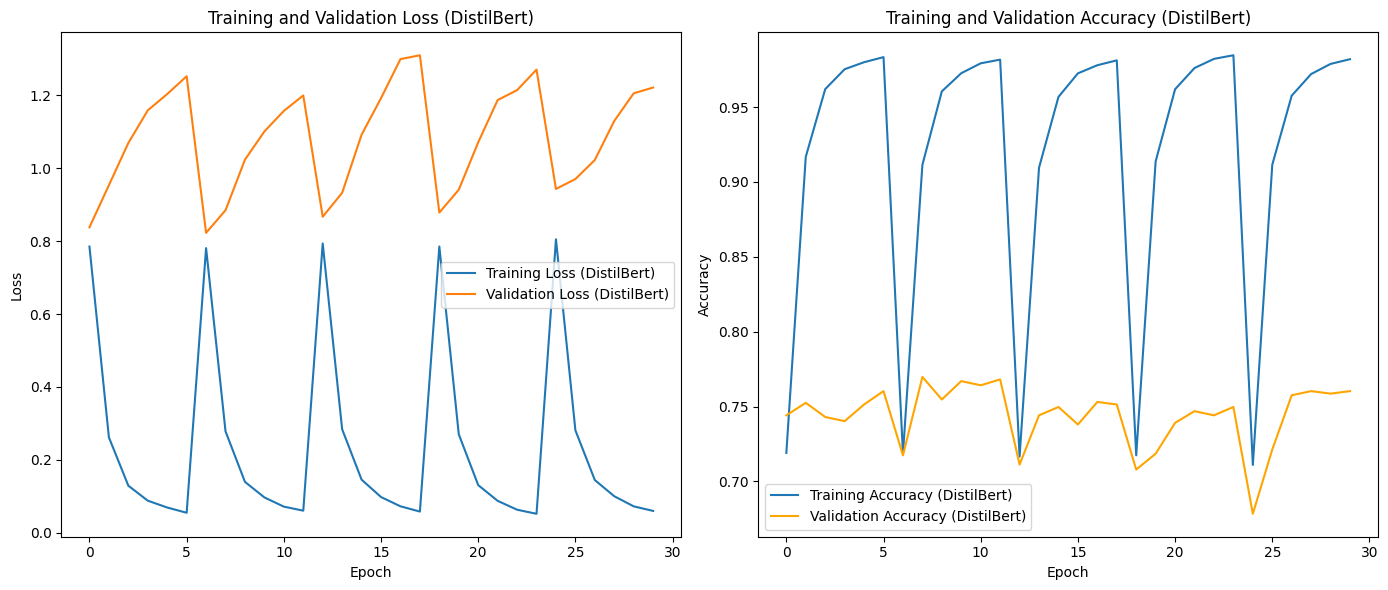

In [ ]:
# TRAIN/VAL CURVES
# =========================
plt.figure(figsize=(14, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses_distilbert, label='Training Loss (DistilBert)')
plt.plot(val_losses_distilbert, label='Validation Loss (DistilBert)')
plt.title('Training and Validation Loss (DistilBert)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_distilbert, label='Training Accuracy (DistilBert)')
plt.plot(val_accuracies_distilbert, label='Validation Accuracy (DistilBert)', color='orange')
plt.title('Training and Validation Accuracy (DistilBert)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


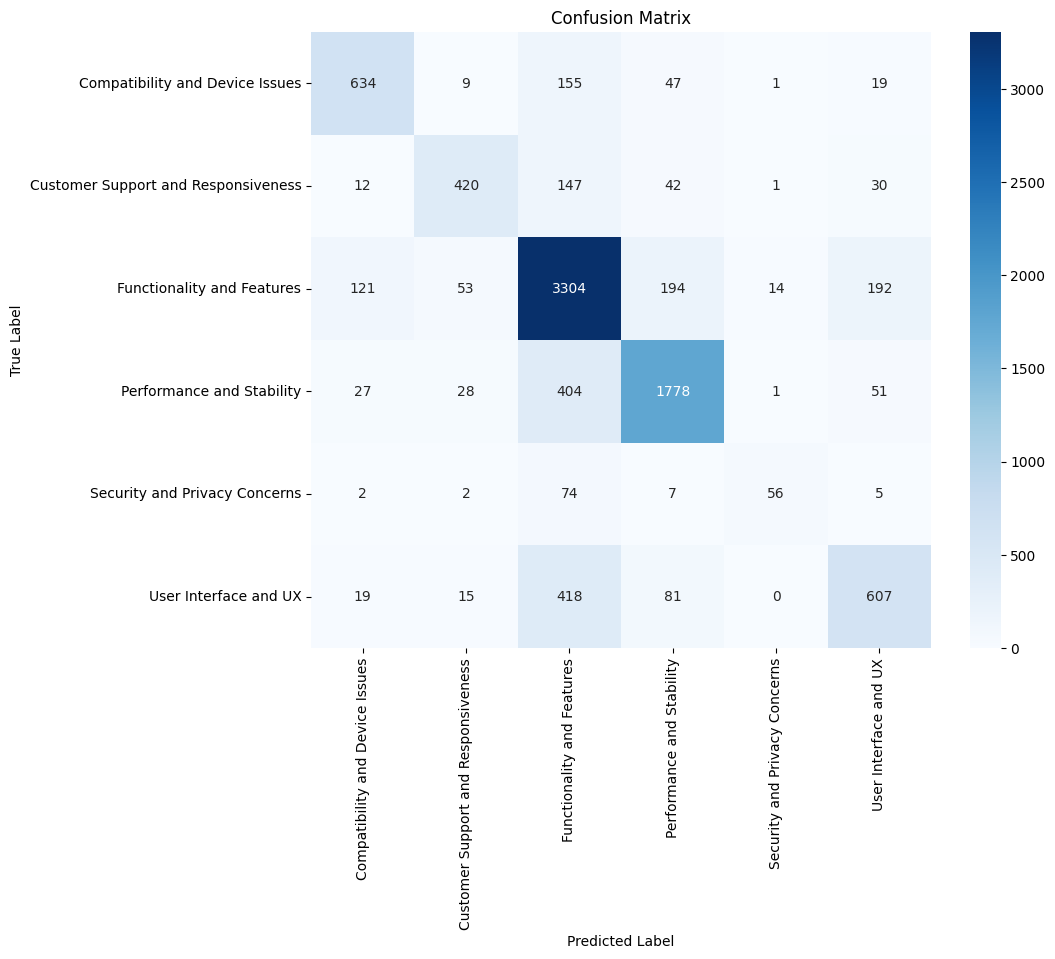

In [ ]:
# CONFUSION MATRIX — AGGREGATED ACROSS ALL FOLDS
# =========================
def plot_confusion_matrix(true_labels, predictions, class_labels):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Use aggregated out-of-fold predictions
true_labels_distilbert = np.array(all_true_labels)
preds_distilbert = np.array(all_pred_labels)
plot_confusion_matrix(true_labels_distilbert, preds_distilbert, class_labels)

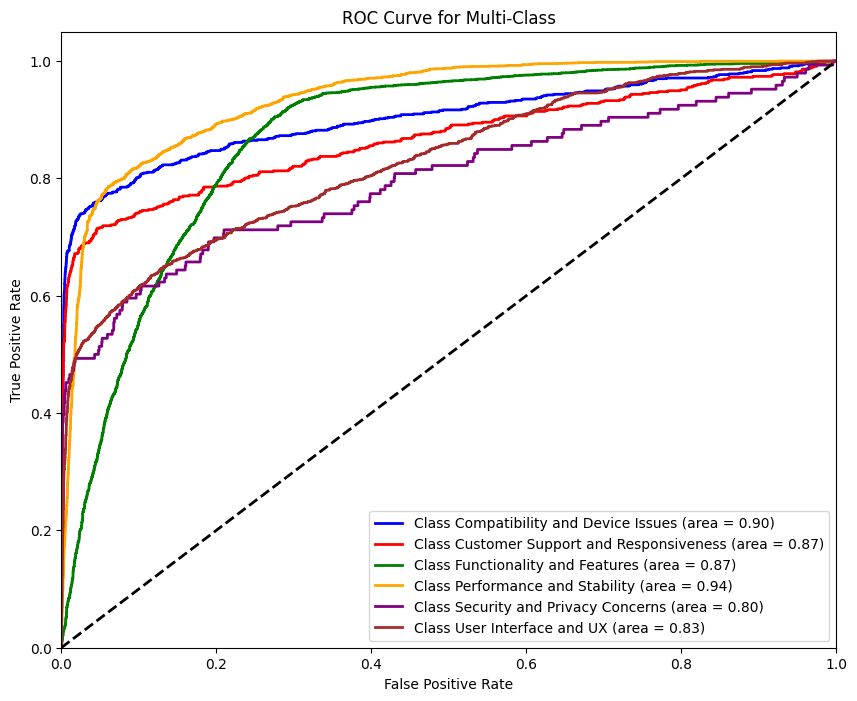

In [ ]:
# ROC CURVES — AGGREGATED ACROSS ALL FOLDS
# =========================
pred_probs_distilbert = np.array(all_pred_probs)

n_classes = len(class_labels)
y_true_bin = label_binarize(true_labels_distilbert, classes=list(range(n_classes)))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs_distilbert[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# CLASSIFICATION REPORT — AGGREGATED ACROSS ALL FOLDS
# =========================
report_distilbert = classification_report(true_labels_distilbert, preds_distilbert, target_names=class_labels)
print("DistilBERT Classification Report:")
print(report_distilbert)

DistilBERT Classification Report:
                                     precision    recall  f1-score   support

    Compatibility and Device Issues       0.78      0.73      0.75       865
Customer Support and Responsiveness       0.80      0.64      0.71       652
         Functionality and Features       0.73      0.85      0.79      3878
          Performance and Stability       0.83      0.78      0.80      2289
      Security and Privacy Concerns       0.77      0.38      0.51       146
              User Interface and UX       0.67      0.53      0.59      1140

                           accuracy                           0.76      8970
                          macro avg       0.76      0.65      0.69      8970
                       weighted avg       0.76      0.76      0.75      8970



In [ ]:
# --- BERT-only: minimal imports (rely on your previous cells) ---
from transformers import BertTokenizerFast, BertForSequenceClassification
import torch.optim as optim

In [ ]:
try:
    upsample_per_class
except NameError:
    from sklearn.utils import resample
    def upsample_per_class(train_df):
        cls_counts = train_df['category'].value_counts()
        majority_n = cls_counts.max()
        upsampled_parts = []
        for cls in cls_counts.index:
            part = train_df[train_df['category'] == cls]
            if len(part) < majority_n:
                part = resample(part, replace=True, n_samples=majority_n, random_state=42)
            upsampled_parts.append(part)
        return pd.concat(upsampled_parts).sample(frac=1.0, random_state=42).reset_index(drop=True)


In [ ]:
try:
    TextDatasetBERT
except NameError:
    from torch.utils.data import Dataset
    class TextDatasetBERT(Dataset):
        def __init__(self, inputs, labels, attention_masks):
            self.inputs = inputs
            self.labels = labels
            self.attention_masks = attention_masks
        def __len__(self):
            return len(self.labels)
        def __getitem__(self, idx):
            return {
                'input_ids': self.inputs[idx].clone().detach().to(torch.long),
                'attention_mask': self.attention_masks[idx].clone().detach().to(torch.long),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }

In [ ]:
# Tokenizer
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Training function (prints per-epoch metrics just like before)
def train_model_bert(train_loader, val_loader, epochs):
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer_bert, num_warmup_steps=0, num_training_steps=total_steps)

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    for epoch in range(epochs):
        model_bert.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            optimizer_bert.zero_grad()
            inputs = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model_bert(inputs, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer_bert.step()
            scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

        avg_train_loss = total_loss / len(train_loader) if len(train_loader) > 0 else 0.0
        avg_train_accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(avg_train_accuracy)

        # Validation
        model_bert.eval()
        val_loss = 0
        correct_predictions = 0
        total_samples = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input_ids'].to(device)
                attention_masks = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model_bert(inputs, attention_mask=attention_masks, labels=labels)
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct_predictions += torch.sum(preds == labels).item()
                total_samples += labels.size(0)

        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0.0
        avg_val_accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(avg_val_accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}')

    return model_bert, history

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# --- K-Fold CV (aggregate across folds; same hyperparams & fixes) ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies_bert = []
train_losses_bert = []
val_losses_bert = []
train_accuracies_bert = []
val_accuracies_bert = []

all_true_labels_bert = []
all_pred_labels_bert = []
all_pred_probs_bert = []

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(df), start=1):
    train_df = df.iloc[train_idx].copy()
    val_df   = df.iloc[val_idx].copy()

    # Upsample TRAIN ONLY
    train_df_bal = upsample_per_class(train_df)

    # Tokenize inside fold
    tokenized_train = bert_tokenizer(
        train_df_bal['Base_Reviews'].astype(str).tolist(),
        padding='max_length', truncation=True, max_length=128, return_tensors='pt', return_attention_mask=True
    )
    tokenized_val = bert_tokenizer(
        val_df['Base_Reviews'].astype(str).tolist(),
        padding='max_length', truncation=True, max_length=128, return_tensors='pt', return_attention_mask=True
    )

    # Labels
    train_labels_fold = train_df_bal['category'].values
    val_labels_fold   = val_df['category'].values

    # Datasets / loaders
    train_dataset_bert = TextDatasetBERT(tokenized_train['input_ids'], train_labels_fold, tokenized_train['attention_mask'])
    val_dataset_bert   = TextDatasetBERT(tokenized_val['input_ids'],   val_labels_fold,   tokenized_val['attention_mask'])

    train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)
    val_loader_bert   = DataLoader(val_dataset_bert,   batch_size=16)

    # Fresh model + optimizer per fold
    model_bert = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased', num_labels=len(df['category'].unique())
    ).to(device)
    optimizer_bert = optim.AdamW(model_bert.parameters(), lr=2e-5)

    # Train
    model_bert, history_bert = train_model_bert(train_loader_bert, val_loader_bert, epochs=6)

    # Collect histories
    train_losses_bert.extend(history_bert['train_loss'])
    val_losses_bert.extend(history_bert['val_loss'])
    train_accuracies_bert.extend(history_bert['train_accuracy'])
    val_accuracies_bert.extend(history_bert['val_accuracy'])

    # Evaluate & aggregate
    model_bert.eval()
    fold_preds, fold_true, fold_probs = [], [], []
    with torch.no_grad():
        for batch in val_loader_bert:
            inputs = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model_bert(inputs, attention_mask=attention_masks)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            preds = torch.argmax(outputs.logits, dim=1)

            fold_probs.extend(probs.cpu().numpy())
            fold_preds.extend(preds.cpu().numpy())
            fold_true.extend(labels.cpu().numpy())

    acc_fold = np.mean(np.array(fold_preds) == np.array(fold_true)) if len(fold_true) > 0 else 0.0
    accuracies_bert.append(acc_fold)

    all_true_labels_bert.extend(fold_true)
    all_pred_labels_bert.extend(fold_preds)
    all_pred_probs_bert.extend(fold_probs)

# CV summary
print(f"BERT Mean CV Accuracy: {np.mean(accuracies_bert):.4f} ± {np.std(accuracies_bert):.4f}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.8037, Train Accuracy: 0.7009, Val Loss: 0.9218, Val Accuracy: 0.6912
Epoch 2, Train Loss: 0.2478, Train Accuracy: 0.9207, Val Loss: 0.9501, Val Accuracy: 0.7598
Epoch 3, Train Loss: 0.1182, Train Accuracy: 0.9657, Val Loss: 1.0436, Val Accuracy: 0.7598
Epoch 4, Train Loss: 0.0848, Train Accuracy: 0.9761, Val Loss: 1.1271, Val Accuracy: 0.7497
Epoch 5, Train Loss: 0.0615, Train Accuracy: 0.9821, Val Loss: 1.2099, Val Accuracy: 0.7625
Epoch 6, Train Loss: 0.0520, Train Accuracy: 0.9826, Val Loss: 1.2046, Val Accuracy: 0.7664


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.7961, Train Accuracy: 0.7095, Val Loss: 0.8279, Val Accuracy: 0.7252
Epoch 2, Train Loss: 0.2424, Train Accuracy: 0.9242, Val Loss: 1.0623, Val Accuracy: 0.7508
Epoch 3, Train Loss: 0.1219, Train Accuracy: 0.9674, Val Loss: 1.0925, Val Accuracy: 0.7464
Epoch 4, Train Loss: 0.0846, Train Accuracy: 0.9758, Val Loss: 1.1526, Val Accuracy: 0.7698
Epoch 5, Train Loss: 0.0647, Train Accuracy: 0.9805, Val Loss: 1.1792, Val Accuracy: 0.7798
Epoch 6, Train Loss: 0.0508, Train Accuracy: 0.9832, Val Loss: 1.2002, Val Accuracy: 0.7776


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.8395, Train Accuracy: 0.6887, Val Loss: 0.8631, Val Accuracy: 0.7341
Epoch 2, Train Loss: 0.2590, Train Accuracy: 0.9186, Val Loss: 1.0043, Val Accuracy: 0.7330
Epoch 3, Train Loss: 0.1229, Train Accuracy: 0.9645, Val Loss: 1.1824, Val Accuracy: 0.7480
Epoch 4, Train Loss: 0.0804, Train Accuracy: 0.9776, Val Loss: 1.2660, Val Accuracy: 0.7575
Epoch 5, Train Loss: 0.0622, Train Accuracy: 0.9805, Val Loss: 1.3194, Val Accuracy: 0.7598
Epoch 6, Train Loss: 0.0498, Train Accuracy: 0.9828, Val Loss: 1.3709, Val Accuracy: 0.7570


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.8961, Train Accuracy: 0.6561, Val Loss: 0.8777, Val Accuracy: 0.7163
Epoch 2, Train Loss: 0.2687, Train Accuracy: 0.9117, Val Loss: 0.9576, Val Accuracy: 0.7458
Epoch 3, Train Loss: 0.1211, Train Accuracy: 0.9645, Val Loss: 1.1238, Val Accuracy: 0.7207
Epoch 4, Train Loss: 0.0742, Train Accuracy: 0.9786, Val Loss: 1.2427, Val Accuracy: 0.7414
Epoch 5, Train Loss: 0.0565, Train Accuracy: 0.9828, Val Loss: 1.2937, Val Accuracy: 0.7258
Epoch 6, Train Loss: 0.0441, Train Accuracy: 0.9862, Val Loss: 1.3400, Val Accuracy: 0.7453


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.8206, Train Accuracy: 0.6963, Val Loss: 0.8924, Val Accuracy: 0.7040
Epoch 2, Train Loss: 0.2654, Train Accuracy: 0.9174, Val Loss: 0.9538, Val Accuracy: 0.7514
Epoch 3, Train Loss: 0.1312, Train Accuracy: 0.9638, Val Loss: 1.0503, Val Accuracy: 0.7598
Epoch 4, Train Loss: 0.0882, Train Accuracy: 0.9763, Val Loss: 1.1442, Val Accuracy: 0.7603
Epoch 5, Train Loss: 0.0684, Train Accuracy: 0.9797, Val Loss: 1.1587, Val Accuracy: 0.7642
Epoch 6, Train Loss: 0.0544, Train Accuracy: 0.9823, Val Loss: 1.1786, Val Accuracy: 0.7715
BERT Mean CV Accuracy: 0.7635 ± 0.0114


In [ ]:
# --- Save last fold model/tokenizer ---
bert_save_directory = '/content/drive/My Drive/bert_model'
os.makedirs(bert_save_directory, exist_ok=True)
model_bert.save_pretrained(bert_save_directory)
bert_tokenizer.save_pretrained(bert_save_directory)
print(f"BERT Model and Tokenizer saved to {bert_save_directory}")

BERT Model and Tokenizer saved to /content/drive/My Drive/bert_model


In [ ]:
# --- Quick inference demo (reuses review_text if defined; else fallback) ---
try:
    review_text
except NameError:
    review_text = "App works fine but crashes when opening settings. Support didn't respond."

loaded_model_bert = BertForSequenceClassification.from_pretrained(bert_save_directory).to(device)
loaded_tokenizer_bert = BertTokenizerFast.from_pretrained(bert_save_directory)

def classify_review_bert(review_text, tokenizer, model, device, class_labels):
    inputs = tokenizer(review_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class_idx = torch.argmax(logits, dim=1).item()
    return class_labels[predicted_class_idx]

predicted_label_bert = classify_review_bert(review_text, loaded_tokenizer_bert, loaded_model_bert, device, class_labels)
print(f"Predicted Label for BERT: {predicted_label_bert}")

Predicted Label for BERT: Customer Support and Responsiveness


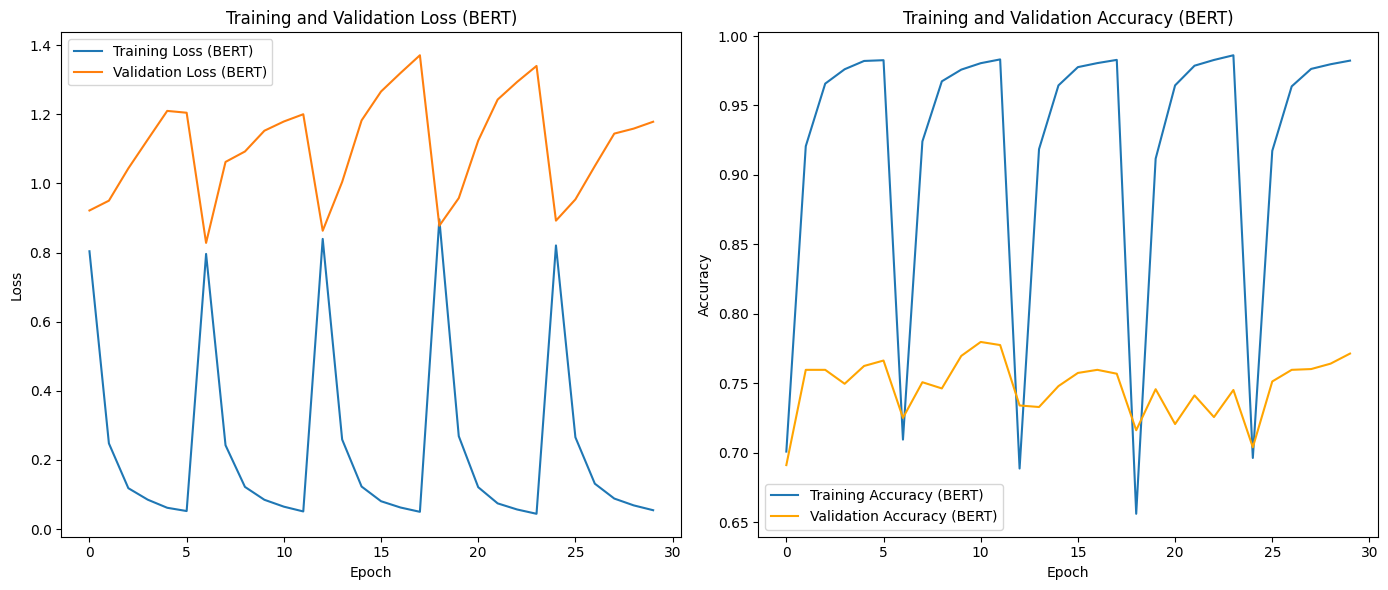

In [ ]:
# --- Training/Validation curves (BERT) ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses_bert, label='Training Loss (BERT)')
plt.plot(val_losses_bert, label='Validation Loss (BERT)')
plt.title('Training and Validation Loss (BERT)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_bert, label='Training Accuracy (BERT)')
plt.plot(val_accuracies_bert, label='Validation Accuracy (BERT)', color='orange')
plt.title('Training and Validation Accuracy (BERT)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

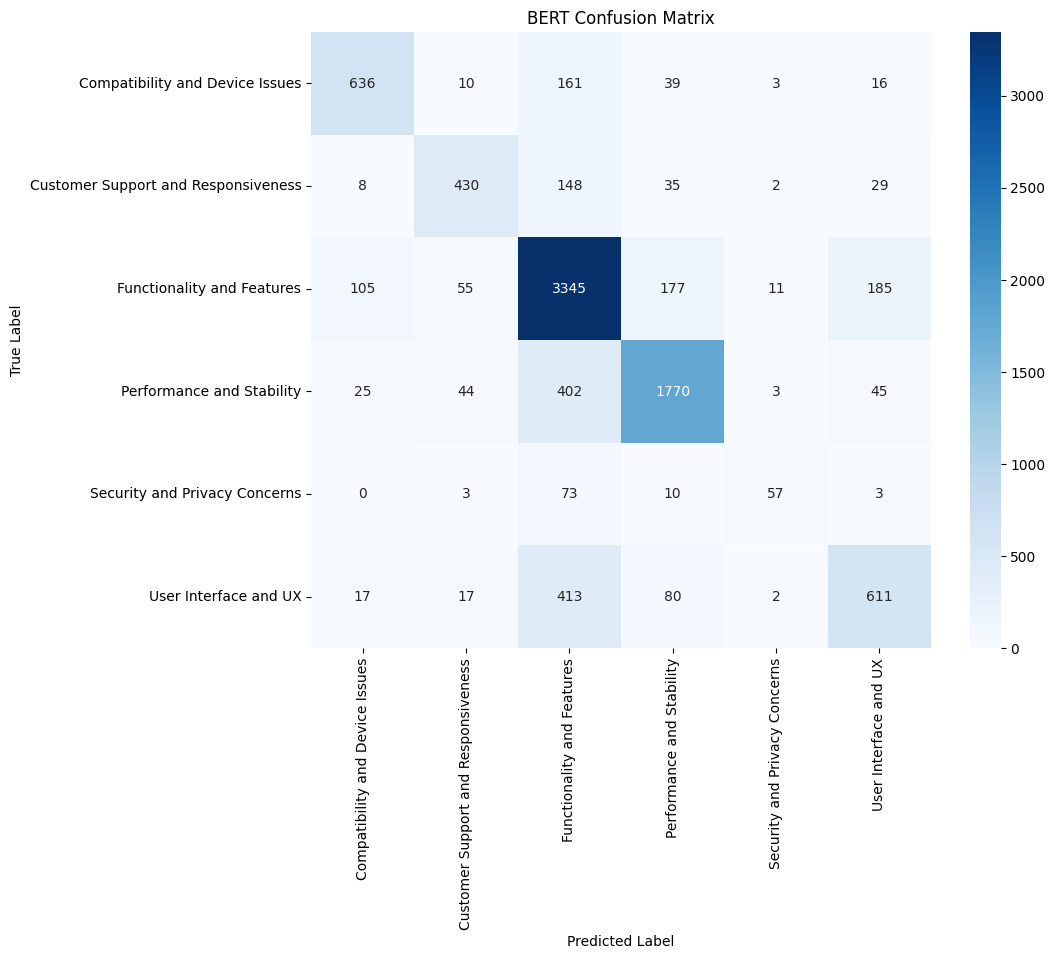

In [ ]:
# --- Confusion matrix (aggregated) ---
cm = confusion_matrix(all_true_labels_bert, all_pred_labels_bert)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.title('BERT Confusion Matrix'); plt.show()


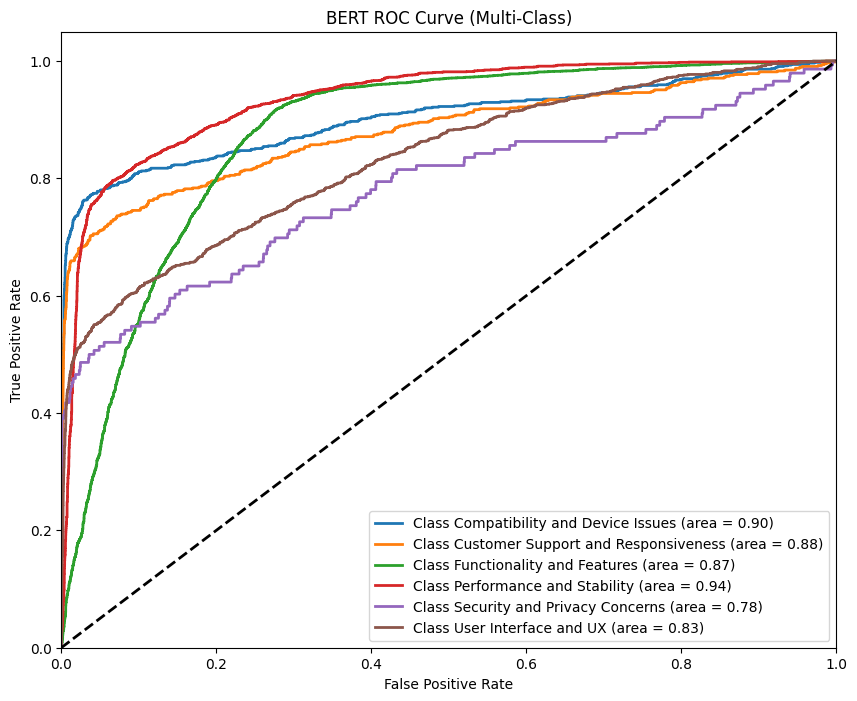

In [ ]:
# --- ROC curves (aggregated) ---
pred_probs_bert = np.array(all_pred_probs_bert)
true_labels_bert = np.array(all_true_labels_bert)
n_classes = len(class_labels)
y_true_bin_bert = label_binarize(true_labels_bert, classes=list(range(n_classes)))

fpr_bert, tpr_bert, roc_auc_bert = {}, {}, {}
for i in range(n_classes):
    fpr_bert[i], tpr_bert[i], _ = roc_curve(y_true_bin_bert[:, i], pred_probs_bert[:, i])
    roc_auc_bert[i] = auc(fpr_bert[i], tpr_bert[i])

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), cycle(['blue','red','green','orange','purple','brown'])):
    plt.plot(fpr_bert[i], tpr_bert[i], lw=2, label=f'Class {class_labels[i]} (area = {roc_auc_bert[i]:0.2f})')
plt.plot([0,1],[0,1],'k--',lw=2)
plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('BERT ROC Curve (Multi-Class)'); plt.legend(loc="lower right"); plt.show()


In [ ]:
# --- Classification report (aggregated) ---
report_bert = classification_report(true_labels_bert, np.array(all_pred_labels_bert), target_names=class_labels)
print("BERT Classification Report:")
print(report_bert)

BERT Classification Report:
                                     precision    recall  f1-score   support

    Compatibility and Device Issues       0.80      0.74      0.77       865
Customer Support and Responsiveness       0.77      0.66      0.71       652
         Functionality and Features       0.74      0.86      0.79      3878
          Performance and Stability       0.84      0.77      0.80      2289
      Security and Privacy Concerns       0.73      0.39      0.51       146
              User Interface and UX       0.69      0.54      0.60      1140

                           accuracy                           0.76      8970
                          macro avg       0.76      0.66      0.70      8970
                       weighted avg       0.77      0.76      0.76      8970

